In [7]:
import joblib
import cv2
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Test pour le SVC

In [8]:

def detect_digits(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 30, 150)
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digits_rois = []
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if w >= 5 and h >= 25:
            roi = gray[y:y + h, x:x + w]
            digits_rois.append((x, y, w, h, roi))
    return img, digits_rois

def square(img, digits_roi):
    for (x, y, w, h, _) in digits_roi:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    return img
    

def recognize_digits(img, digits_rois, model):
    digits = []
    for (x, y, w, h, roi) in digits_rois:
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = roi / 255.0  # Normalisation simple
        roi = roi.reshape(1, 28*28)  # Aplatir l'image pour correspondre à l'entrée du modèle

        # Utiliser les noms de caractéristiques corrects
        feature_names = [f'pixel{i}' for i in range(1, 28*28 + 1)]
        roi_df = pd.DataFrame(roi, columns=feature_names)

        digit = model.predict(roi_df)
        probabilities = model.predict_proba(roi_df)[0]
        print(f"Digit: {digit[0]}, Probabilities: {probabilities}")

        digit = digit[0]  # Obtenir la prédiction réelle à partir du résultat
        digits.append((x, y, digit, probabilities))
        cv2.putText(img, str(digit), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
    
    # Utiliser matplotlib pour afficher l'image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Digits Recognized")
    plt.axis('off')
    plt.show()
    
    return digits


In [9]:
image_path = './data/parties/25_08_2024/partie_25_08_2024_rognee.jpg'
img, digits_rois = detect_digits(image_path)
img = square(img, digits_rois)
print(digits_rois)

[(74, 1169, 22, 27, array([[136, 133, 137, 137, 130, 131, 136, 132, 132, 132, 133, 132, 143,
        139, 122, 111, 100,  94,  92,  91, 136, 135],
       [164, 129, 117, 130, 139, 123, 133, 143, 124, 122, 142, 149, 144,
         82,  36,  35,  45,  48,  42,  48,  76, 129],
       [149, 125, 129, 146, 136, 123, 136, 137, 127, 136, 141, 125,  42,
         65,  78, 100, 121, 128,  85,  33,  71, 125],
       [146, 136, 138, 143, 129, 121, 129, 138, 126, 141, 128,  80,  23,
         81, 122, 115, 141, 160, 115,  35,  66, 119],
       [131, 123, 118, 118, 121, 121, 129, 123, 133, 145, 114,  40,  60,
        118, 144, 135, 134, 148, 103,  25,  83, 126],
       [156, 140, 143, 150, 128, 125, 136, 131, 126, 146, 115,  42,  42,
         92, 138, 159, 160, 120,  62,  16, 113, 134],
       [111, 116, 141, 147, 129, 126, 136, 143, 136, 148, 128,  74,  29,
         36,  73, 110, 103,  74,  55,  60, 122, 147],
       [ 54,  59,  82,  84, 117, 107, 127, 142, 134, 140, 142, 125,  75,
         59,  46, 

Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512105 0.099662   0.01542108 0.11490604
 0.05120658 0.04213432 0.06709272 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.050190

C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler wa

Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.099662   0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019047 0.0077936  0.52512103 0.099662   0.01542108 0.11490605
 0.05120658 0.04213432 0.06709272 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019557 0.00779115 0.52514558 0.09965207 0.01541729 0.11489411
 0.05120025 0.04212276 0.06711192 0.0264693 ]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.050190

C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler wa

Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]


C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler wa

Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019046 0.00779358 0.52512188 0.0996617  0.01542104 0.11490578
 0.05120657 0.04213418 0.06709275 0.02647207]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512103 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647214]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.050190

C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\Nathan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler wa

Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]
Digit: 2, Probabilities: [0.05019048 0.0077936  0.52512102 0.09966201 0.01542108 0.11490605
 0.05120658 0.04213432 0.06709271 0.02647215]


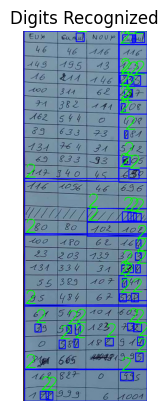

[(74, 1169, '2', array([0.05019048, 0.0077936 , 0.52512102, 0.09966201, 0.01542108,
       0.11490605, 0.05120658, 0.04213432, 0.06709271, 0.02647215])), (55, 1168, '2', array([0.05019048, 0.0077936 , 0.52512102, 0.09966201, 0.01542108,
       0.11490605, 0.05120658, 0.04213432, 0.06709271, 0.02647215])), (314, 1106, '2', array([0.05019048, 0.0077936 , 0.52512102, 0.09966201, 0.01542108,
       0.11490605, 0.05120658, 0.04213432, 0.06709271, 0.02647215])), (5, 1096, '2', array([0.05019048, 0.0077936 , 0.52512102, 0.09966201, 0.01542108,
       0.11490605, 0.05120658, 0.04213432, 0.06709271, 0.02647215])), (363, 1044, '2', array([0.05019048, 0.0077936 , 0.52512102, 0.09966201, 0.01542108,
       0.11490605, 0.05120658, 0.04213432, 0.06709271, 0.02647215])), (116, 1002, '2', array([0.05019048, 0.0077936 , 0.52512105, 0.099662  , 0.01542108,
       0.11490604, 0.05120658, 0.04213432, 0.06709272, 0.02647215])), (164, 999, '2', array([0.05019048, 0.0077936 , 0.52512102, 0.09966201, 0.015421

In [10]:
model = joblib.load('./models/DetectionReconize_optimized2.pkl')
digits = recognize_digits(img, digits_rois, model)
print(digits)

# Test pour le CNN

In [11]:
import cv2
import matplotlib.pyplot as plt

def recognize_digits_cnn(img, digits_rois, model):
    digits = []
    for (x, y, w, h, roi) in digits_rois:
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = roi / 255.0  # Normalisation simple
        roi = roi.reshape(1, 28, 28, 1)  # Reshape pour correspondre à l'entrée du modèle CNN (batch_size, height, width, channels)

        digit = model.predict(roi)
        digit_class = digit.argmax()  # Obtenir la prédiction réelle à partir du résultat
        probabilities = digit[0]  # Obtenir les probabilités

        digits.append((x, y, digit_class, probabilities))
        cv2.putText(img, str(digit_class), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
    
    # Utiliser matplotlib pour afficher l'image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Digits Recognized")
    plt.axis('off')
    plt.show()
    
    return digits

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

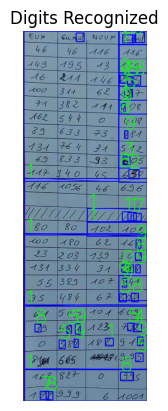

[(74, 1169, 8, array([0.09833404, 0.06772622, 0.21061091, 0.05947043, 0.04858107,
       0.08526784, 0.07734371, 0.07931229, 0.2262093 , 0.04714417],
      dtype=float32)), (55, 1168, 7, array([0.04700693, 0.1371254 , 0.11067596, 0.08519695, 0.10071307,
       0.07730971, 0.02975403, 0.23155731, 0.0897287 , 0.09093196],
      dtype=float32)), (314, 1106, 8, array([0.11468343, 0.12278534, 0.09376519, 0.08874071, 0.08869126,
       0.10730906, 0.05212237, 0.0986051 , 0.13029803, 0.10299959],
      dtype=float32)), (5, 1096, 1, array([0.10654646, 0.13680474, 0.092237  , 0.09299291, 0.09267177,
       0.09964085, 0.05689335, 0.08463891, 0.11708397, 0.12048998],
      dtype=float32)), (363, 1044, 5, array([0.05501236, 0.07688077, 0.05776547, 0.14730802, 0.05883595,
       0.29243582, 0.047564  , 0.04612673, 0.13618395, 0.08188694],
      dtype=float32)), (116, 1002, 5, array([0.0456709 , 0.04714641, 0.06613149, 0.13417247, 0.03731523,
       0.275642  , 0.05491614, 0.03669126, 0.22087249, 0

In [12]:
model_CNN = load_model('./models/DetectionReconize_CNN.h5') # Utiliser load_model pour le modèle CNN
img, digits_rois = detect_digits(image_path)
img = square(img, digits_rois)  
digits_Cnn = recognize_digits_cnn(img, digits_rois, model_CNN)

print(digits_Cnn)